In [11]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
X_train = pd.read_csv("./X_train_clean_knn.csv")
X_test = pd.read_csv("./X_test_clean_knn.csv")
y_train = pd.read_csv("./y_train_knn.csv")
y_test = pd.read_csv("./y_test_knn.csv")

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(242, 17)
(61, 17)
(242, 1)
(61, 1)


# Classification k-NN

In [14]:
#hyperparameters_knn
n_neighbors=5
weights='uniform'
algorithm='auto'
leaf_size=30
p=2
metric='minkowski'

In [15]:
model_knn = KNeighborsClassifier(
    n_neighbors=n_neighbors,
    weights=weights,
    algorithm=algorithm,
    leaf_size=leaf_size,
    p=p,
    metric=metric,
)

In [16]:
model_knn

KNeighborsClassifier()

#### Entraînement du modèle

In [17]:
model_knn.fit(X_train.values, y_train.values.ravel())

KNeighborsClassifier()

#### Prédictions
https://github.com/scikit-learn/scikit-learn/issues/26768  
Bug avec scikit-learn 1.3.0 : predict ne prend en argument qu'un numpy array et non un pandas DataFrame.  
Avec scikit-learn < 1.3.0:
```
y_pred = model_knn.predict(X_test)
```

In [18]:
y_pred = model_knn.predict(X_test.values)

#### Évaluation du modèle

In [19]:
accuracy_score(y_pred, y_test)

0.819672131147541

## Recherche des meilleurs hyperparamètres avec RandomizedSearchCV

In [27]:
"""
hyperparameters = {
    "n_neighbors" : list(range(3,20)),
    "weights"     : ["uniform", "distance"],
    "algorithm"   : ["ball_tree", "kd_tree"],
    "p"           : list(range(2,5))
}
"""

# Avec gestion des combinaisons non valides d'hyperparamètres :
hyperparameters = [
    {
        "n_neighbors" : list(range(3,20)),
        "weights"     : ["uniform", "distance"],
        "algorithm"   : ["ball_tree", "kd_tree"],
        "p"           : list(range(2,5)),
        "metric"      : ["minkowski"]
    },
    {
        "n_neighbors" : list(range(3,20)),
        "weights"     : ["uniform", "distance"],
        "algorithm"   : ["ball_tree", "kd_tree"],
        "metric"      : ["manhattan"]
    },
]

In [28]:
gscv_knn = RandomizedSearchCV(
    estimator = model_knn,
    param_distributions = hyperparameters,
    cv = 5,
    scoring = "f1",
    verbose = 4
)

In [29]:
gscv_knn.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=4, p=2, weights=distance;, score=0.762 total time=   0.0s
[CV 2/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=4, p=2, weights=distance;, score=0.837 total time=   0.0s
[CV 3/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=4, p=2, weights=distance;, score=0.756 total time=   0.0s
[CV 4/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=4, p=2, weights=distance;, score=0.826 total time=   0.0s
[CV 5/5] END algorithm=ball_tree, metric=minkowski, n_neighbors=4, p=2, weights=distance;, score=0.773 total time=   0.0s
[CV 1/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=17, p=2, weights=distance;, score=0.714 total time=   0.0s
[CV 2/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=17, p=2, weights=distance;, score=0.864 total time=   0.0s
[CV 3/5] END algorithm=kd_tree, metric=minkowski, n_neighbors=17, p=2, weights=distance

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'algorithm': ['ball_tree', 'kd_tree'],
                                         'metric': ['minkowski'],
                                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19],
                                         'p': [2, 3, 4],
                                         'weights': ['uniform', 'distance']},
                                        {'algorithm': ['ball_tree', 'kd_tree'],
                                         'metric': ['manhattan'],
                                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12, 13, 14, 15,
                                                         16, 17, 18, 19],
                                         'weights': ['uniform', 'distance']}],
                   scoring='f1', verbose=4)

In [30]:
best_knn = gscv_knn.best_estimator_

In [31]:
best_knn_hyperparameters = gscv_knn.best_params_

In [33]:
best_knn_hyperparameters

{'weights': 'distance',
 'n_neighbors': 14,
 'metric': 'manhattan',
 'algorithm': 'ball_tree'}

In [34]:
y_pred = best_knn.predict(X_test)

In [35]:
print("Accuracy  :", accuracy_score(y_pred, y_test.values))
print("Precision :", precision_score(y_pred, y_test.values))
print("Recall    :", recall_score(y_pred, y_test.values))
print("F1        :", f1_score(y_pred, y_test.values))

Accuracy  : 0.819672131147541
Precision : 0.75
Recall    : 0.84
F1        : 0.7924528301886793


In [36]:
cm = confusion_matrix(y_pred, y_test.values)

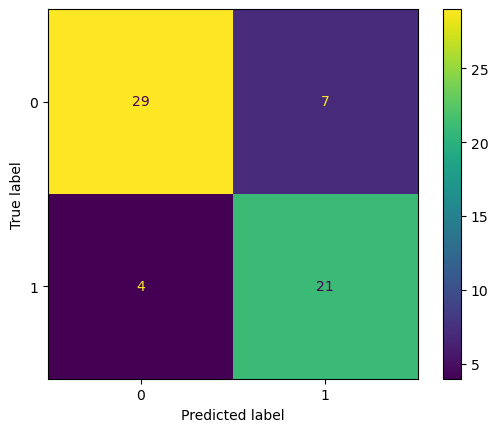

In [37]:
cmd = ConfusionMatrixDisplay(confusion_matrix = cm)
cmd.plot()

In [38]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.75      0.84      0.79        25

    accuracy                           0.82        61
   macro avg       0.81      0.82      0.82        61
weighted avg       0.83      0.82      0.82        61



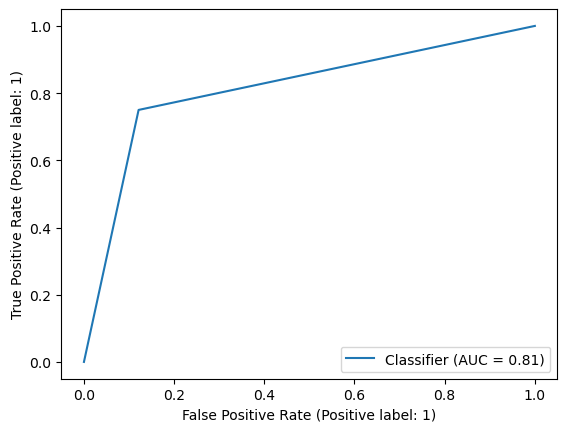

In [39]:
RocCurveDisplay.from_predictions(y_test, y_pred)

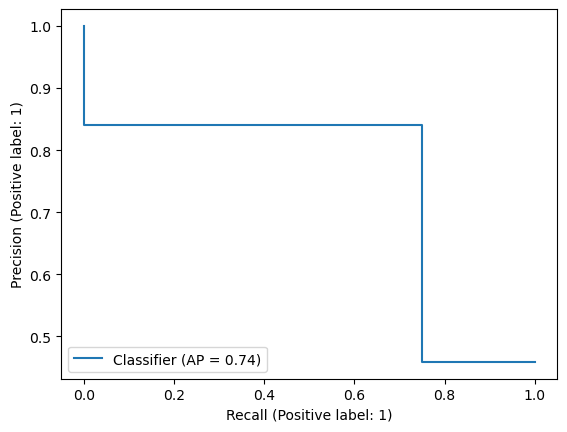

In [40]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)